# Data Exploration

Loading Data and importing requirements

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/Teeth DataSet.zip" -d /content/data

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import json

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Teeth_Dataset/Validation/CoS/b_111_0_6094.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/CoS/b_150_0_2905.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/OT/ot_1241_0_1157.jpg  
  inflating: /content/data/Teeth_Dataset/Validation/CoS/b_95 - Copy_0_6372.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/CaS/a_152_0_7749.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/CaS/a_126_0_9339.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/outputs/a_110_0_9820.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/outputs/a_141_0_7620.jpg  
  inflating: /content/data/Teeth_Dataset/Validation/CoS/b_132_0_2266.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/outputs/a_99_0_9803.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/OT/ot_1223_0_6812.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/OT/ot_1223_0_6082.jpg  
  inflating: /content/data/Teeth_Dataset/Testing/output/

Check GPU

In [3]:
print("🔍 Checking GPU availability...")
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))
print()

if len(tf.config.list_physical_devices('GPU')) == 0:
    print("⚠️ WARNING: No GPU detected! Training will be VERY slow.")
    print("   Fix: Runtime → Change runtime type → GPU → Save")
    print()
else:
    print("✅ GPU is available! Training will be fast.")
    print()

🔍 Checking GPU availability...
Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ GPU is available! Training will be fast.



Create Output Directories

In [4]:
!mkdir -p /content/drive/MyDrive/teeth_classification/outputs/figures
!mkdir -p /content/drive/MyDrive/teeth_classification/outputs/models
!mkdir -p /content/drive/MyDrive/teeth_classification/outputs/results

Data Paths

In [11]:
BASE_DIR = '/content/data/Teeth_Dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
VALID_DIR = os.path.join(BASE_DIR, 'Validation')
TEST_DIR = os.path.join(BASE_DIR, 'Testing')

# Check folders exist
print(f"Training folder exists: {os.path.exists(TRAIN_DIR)}")
print(f"Validation folder exists: {os.path.exists(VALID_DIR)}")
print(f"Testing folder exists: {os.path.exists(TEST_DIR)}")
print()

print(os.listdir(TRAIN_DIR))
print(os.listdir(VALID_DIR))
print(os.listdir(TEST_DIR))

Training folder exists: True
Validation folder exists: True
Testing folder exists: True

['OLP', 'Gum', 'CaS', 'OT', 'OC', 'CoS', 'MC']
['OLP', 'Gum', 'CaS', 'OT', 'OC', 'CoS', 'MC']
['OLP', 'outputs', 'Gum', 'CaS', 'out', 'output', 'OT', 'output_image.jpg', 'OC', 'CoS', 'MC']


Explore Data

In [12]:
class_names = sorted(os.listdir(TRAIN_DIR))
print(f"Classes found: {class_names}")
print(f"Number of classes: {len(class_names)}")
print()

class_counts = {}
for class_name in class_names:
    class_path = os.path.join(TRAIN_DIR, class_name)
    count = len(os.listdir(class_path))
    class_counts[class_name] = count
    print(f"  {class_name}: {count} images")

print(f"\nTotal training images: {sum(class_counts.values())}")
print()

Classes found: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Number of classes: 7

  CaS: 480 images
  CoS: 450 images
  Gum: 360 images
  MC: 540 images
  OC: 324 images
  OLP: 540 images
  OT: 393 images

Total training images: 3087



Visualize Class Distribution



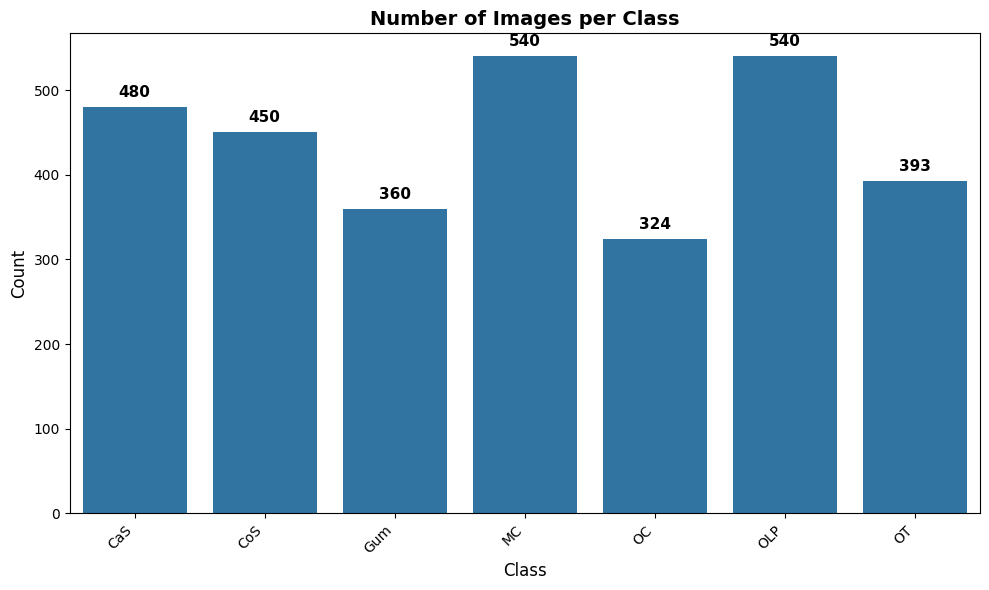

✅ Saved: class_distribution.png



In [14]:
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45, ha='right')
plt.title("Number of Images per Class", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add counts on top of bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/teeth_classification/outputs/figures/class_distribution.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: class_distribution.png\n")

Sample Images from each Class

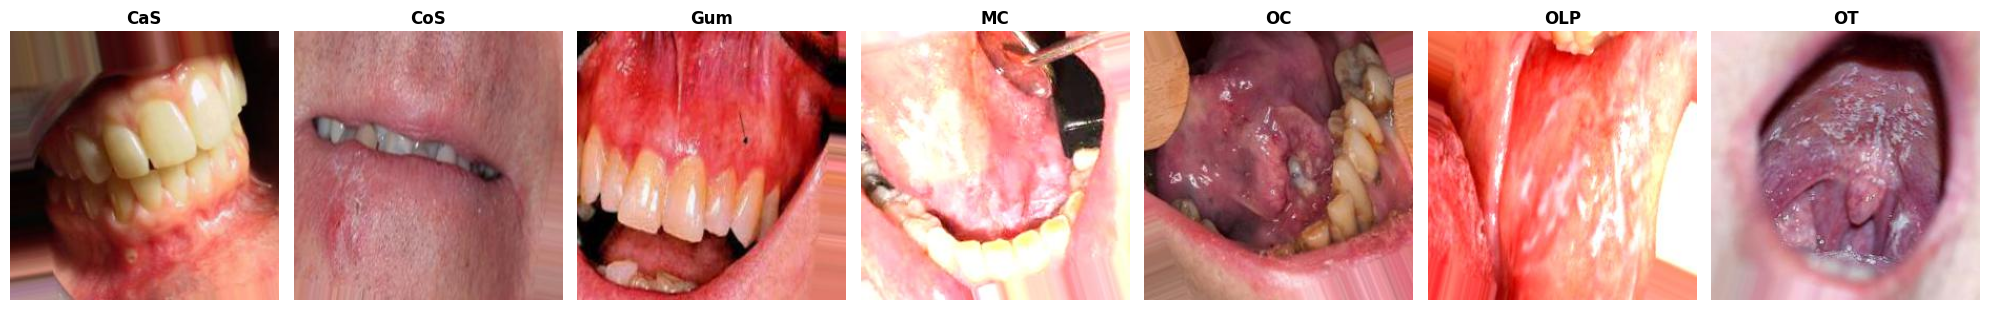

✅ Saved: sample_images_per_class.png



In [15]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, 7, figsize=(20, 3))

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(TRAIN_DIR, class_name)
    img_name = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, img_name)

    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name, fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/teeth_classification/outputs/figures/sample_images_per_class.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: sample_images_per_class.png\n")


# Preprocessing

Define augmentation and normalization

In [48]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

normalization_layer = tf.keras.layers.Rescaling(1./255)

Load dataset

In [49]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

print("Loading datasets...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("✅ Datasets loaded\n")

Loading datasets...
Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
✅ Datasets loaded



Visualize Augmentation

Generating augmentation examples...


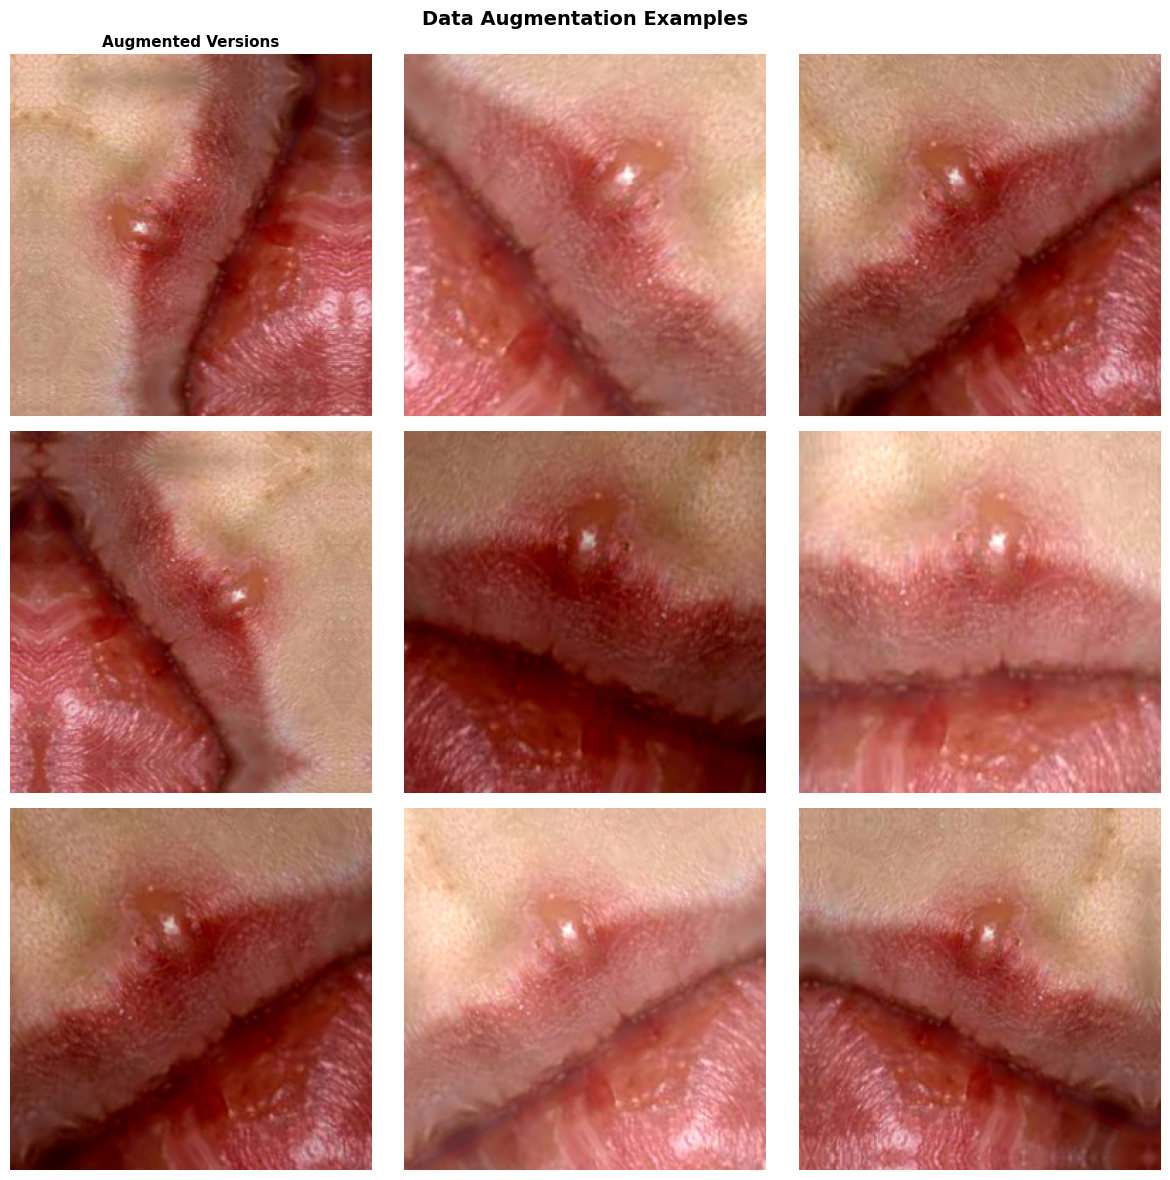

✅ Saved: augmentation_examples.png



In [51]:
print("Generating augmentation examples...")

for images, labels in train_ds.take(1):
    original_image = images[0]

plt.figure(figsize=(12, 12))
for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training=True)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    if i == 0:
        plt.title("Augmented Versions", fontsize=11, fontweight='bold')
    plt.axis("off")

plt.suptitle("Data Augmentation Examples", fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/teeth_classification/outputs/figures/augmentation_examples.png',
            dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: augmentation_examples.png\n")


Optimize Data Pipeline

In [52]:
def prepare(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda x,y: (normalization_layer(x), y))
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)


Preprocessing model

In [53]:
preprocess = tf.keras.Sequential([
    data_augmentation,
    normalization_layer
])

# Build CNN Model

In [63]:
NUM_CLASSES = len(class_names)

model = tf.keras.Sequential([
    layers.Input(shape=(256, 256, 3)),
    preprocess,

    # 1st conv block
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # 2nd conv block
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # 3rd conv block
    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Flatten(),

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,872,903 (64.37 MB)

 Trainable params: 16,872,199 (64.36 MB)

 Non-trainable params: 704 (2.75 KB)

# Training the Model

Setup Callbacks

In [65]:
# Save best model
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/teeth_classification/outputs/models/baseline_cnn_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Reduce learning rate if val_loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, lr_reduce]

In [66]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 377ms/step - accuracy: 0.1371 - loss: 2.4802 - val_accuracy: 0.1751 - val_loss: 1.9563 - learning_rate: 3.0000e-04
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.1426 - loss: 2.2537 - val_accuracy: 0.1751 - val_loss: 1.9343 - learning_rate: 3.0000e-04
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - accuracy: 0.1479 - loss: 2.2299 - val_accuracy: 0.1751 - val_loss: 1.9440 - learning_rate: 3.0000e-04
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.1539 - loss: 2.1718 - val_accuracy: 0.1751 - val_loss: 1.9316 - learning_rate: 3.0000e-04
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.1689 - loss: 2.1693 - val_accuracy: 0.1751 - val_loss: 1.9421 - learning_rate: 3.0000e-04
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.1747 - loss: 2.1227 - val_accuracy: 0.1751 - val_loss: 1.9339 - learning_rate: 3.0000e-04
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accu

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['Train','Val'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Val'])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/teeth_classification/outputs/figures/training_curves.png',
            dpi=300)
plt.show()

In [27]:
import os
import shutil

TEST_DIR = "/content/data/Teeth_Dataset/Testing"

# List everything in Testing
for item in os.listdir(TEST_DIR):
    path = os.path.join(TEST_DIR, item)

    # Delete files
    if os.path.isfile(path):
        os.remove(path)
        print(f"Deleted file: {path}")

    # Delete unrelated folders
    elif os.path.isdir(path):
        # Only delete if it's NOT one of the 7 class folders
        if item not in ['CaS','CoS','Gum','MC','OC','OLP','OT']:
            shutil.rmtree(path)
            print(f"Deleted folder: {path}")

# Verify remaining contents
print("Remaining folders in Testing:", os.listdir(TEST_DIR))


Remaining folders in Testing: ['OLP', 'Gum', 'CaS', 'OT', 'OC', 'CoS', 'MC']


In [28]:
# Check your dataset size
print("Dataset sizes:")
print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

# Estimate total images
train_size = len(train_ds) * BATCH_SIZE
val_size = len(val_ds) * BATCH_SIZE
test_size = len(test_ds) * BATCH_SIZE

print(f"\nEstimated images:")
print(f"Training: ~{train_size}")
print(f"Validation: ~{val_size}")
print(f"Testing: ~{test_size}")

Dataset sizes:
Training batches: 97
Validation batches: 33
Test batches: 48

Estimated images:
Training: ~3104
Validation: ~1056
Testing: ~1536


# Evaluation

In [ ]:
print("📊 Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_ds)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*60 + "\n")

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

with open('/content/drive/MyDrive/teeth_classification/outputs/results/classification_report.txt','w') as f:
    f.write(report)

Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.savefig('/content/drive/MyDrive/teeth_classification/outputs/figures/confusion_matrix.png',
            dpi=300)
plt.show()

In [ ]:
results = {
    "final_train_accuracy": float(history.history['accuracy'][-1]),
    "final_val_accuracy": float(history.history['val_accuracy'][-1])
}

with open('/content/drive/MyDrive/teeth_classification/outputs/results/baseline_metrics.json','w') as f:
    json.dump(results, f, indent=4)